# Federico Ariton
# Master of Science in Data Analytics
# Semester 2 - CA2 Integreated
# Student Number: sba22090


In [1]:
import praw
import json
import time
from kafka import KafkaProducer
from datetime import datetime

# Reddit API
reddit = praw.Reddit(
    client_id="ZIiiYBtVEmgfjD-O5ptc7Q",
    client_secret="0pY__37oIdAp1PXiD3vRhUw7RNo6dQ",
    user_agent='BDSP2025:v1.0 (by /u/Fun-Star2608)'
)

# Kafka Producer
producer = KafkaProducer(
    bootstrap_servers='localhost:9092',
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

# Output File
output_file = "reddit_tsla.jsonl"

def fetch_and_send_posts(subreddit_name="worldnews", keyword="TSLA", limit=5):
    posts_sent = 0
    with open(output_file, "a") as f:
        for post in reddit.subreddit(subreddit_name).search(keyword, sort="new", limit=limit):
            post_data = {
                "id": post.id,
                "title": post.title,
                "selftext": post.selftext or "",
                "created_utc": datetime.utcfromtimestamp(post.created_utc).isoformat(),
                "score": post.score,
                "num_comments": post.num_comments,
                "url": post.url,
                "subreddit": post.subreddit.display_name
            }
            # Send to Kafka
            producer.send("reddit-news", post_data)
            # Store locally
            f.write(json.dumps(post_data) + "\n")
            print(f"Sent & Saved: {post_data['title'][:60]}")
            posts_sent += 1
    return posts_sent

def interactive_loop():
    while True:
        subreddit = input("Enter subreddit name (default=worldnews): ").strip() or "worldnews"
        keyword = input("Enter keyword to search (default=TSLA): ").strip() or "TSLA"
        limit = input("How many posts to fetch (default=5): ").strip()
        try:
            limit = int(limit)
        except ValueError:
            limit = 5

        repeat_count = input("How many times do you want to repeat the fetch (every 30 seconds)? ").strip()
        try:
            repeat_count = int(repeat_count)
        except ValueError:
            repeat_count = 1

        for i in range(repeat_count):
            print(f"\nRound {i+1}/{repeat_count} at {datetime.utcnow().isoformat()} UTC")
            sent = fetch_and_send_posts(subreddit_name=subreddit, keyword=keyword, limit=limit)
            print(f"Total posts sent this round: {sent}")
            if i < repeat_count - 1:
                print("Waiting 30 seconds...")
                time.sleep(30)

        again = input("\nDo you want to run another session? (yes/no): ").strip().lower()
        if again != 'yes':
            print("\nFinished. Exiting program.")
            break

        print("\nRestarting...\n")
        time.sleep(2)

# Run
if __name__ == "__main__":
    interactive_loop()
    producer.flush()


Version 7.1.4 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


Enter subreddit name (default=worldnews): worldnews
Enter keyword to search (default=TSLA): 
How many posts to fetch (default=5): 
How many times do you want to repeat the fetch (every 30 seconds)? 2

Round 1/2 at 2025-05-16T11:25:55.026641 UTC
Sent & Saved: Tesla Inc (TSLA) Shares Bought by Candriam Luxembourg S.C.A.
Sent & Saved: Tesla Inc (TSLA.O) Chief Executive Elon Musk’s decision to a
Sent & Saved: Investors in the debt of electric carmaker Tesla (TSLA.O) ar
Sent & Saved: Saudi Arabia’s Public Investment Fund (PIF) has shown no int
Sent & Saved: Tesla Inc’s (TSLA.O) board of directors is seeking more info
Total posts sent this round: 5
Waiting 30 seconds...

Round 2/2 at 2025-05-16T11:26:25.767038 UTC
Sent & Saved: Tesla Inc (TSLA) Shares Bought by Candriam Luxembourg S.C.A.
Sent & Saved: Tesla Inc (TSLA.O) Chief Executive Elon Musk’s decision to a
Sent & Saved: Investors in the debt of electric carmaker Tesla (TSLA.O) ar
Sent & Saved: Saudi Arabia’s Public Investment Fund (PIF)

In [2]:
import json
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["tsla_data"]
collection = db["reddit_posts"]

# Read from JSONL and insert
with open("reddit_tsla.jsonl", "r") as f:
    records = [json.loads(line) for line in f if line.strip()]
    if records:
        collection.insert_many(records)
        print(f" Inserted {len(records)} Reddit posts into MongoDB.")
    else:
        print("No records found in file.")


 Inserted 60 Reddit posts into MongoDB.


                        _id       id  \
0  68271e5459eaa60ca700cfa9  1kn7o0m   
1  68271e5459eaa60ca700cfaa  1kmua7t   
2  68271e5459eaa60ca700cfab  1kmeu35   
3  68271e5459eaa60ca700cfac  1klx4t2   
4  68271e5459eaa60ca700cfad  1klu5q8   

                                               title          created_utc  \
0  (05/15) Interesting Stocks Today - DOJ investi...  2025-05-15T13:03:14   
1                        UNH feels like the new TSLA  2025-05-14T23:53:32   
2  (05/14) Interesting Stocks Today - Semis Strik...  2025-05-14T13:13:32   
3  SPMO (Invesco S&P 500 Momentum ETF) Hits New 5...  2025-05-13T20:54:23   
4  Tesla Calls One-Time +$57,724, Buy/Sell Timing...  2025-05-13T18:55:25   

   score  num_comments                                                url  \
0     15            10  https://www.reddit.com/r/stocks/comments/1kn7o...   
1      0            42  https://www.reddit.com/r/stocks/comments/1kmua...   
2     14             4  https://www.reddit.com/r/stocks/comments/

<AxesSubplot:title={'center':'Posts per Day'}, xlabel='created_utc'>

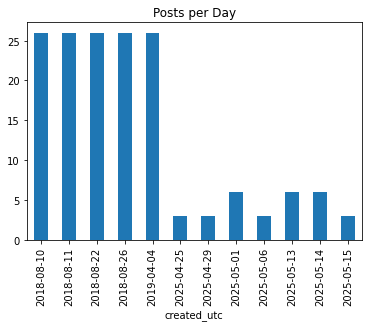

In [3]:
import pandas as pd

client = MongoClient("mongodb://localhost:27017/")
db = client["tsla_data"]
collection = db["reddit_posts"]

# Load into DataFrame
df = pd.DataFrame(list(collection.find()))
print(df.head())

# convert created_utc to datetime
df["created_utc"] = pd.to_datetime(df["created_utc"])

# Plot posts over time
df["created_utc"].dt.date.value_counts().sort_index().plot(kind="bar", title="Posts per Day")


## Stock data API from Yahoo Finance

In [4]:
import yfinance as yf
import pandas as pd

# Fetch TSLA prices (latest 1 day at 1-minute interval)
tsla = yf.Ticker("TSLA")
hist = tsla.history(period="1d", interval="1m")

# Reset index and rename columns
hist = hist.reset_index()[["Datetime", "Close"]]
hist.columns = ["timestamp", "close_price"]

# Save to CSV
hist.to_csv("tsla_price.csv", index=False)
print("Saved TSLA price data to tsla_price.csv")


Saved TSLA price data to tsla_price.csv


In [5]:
stock_df = pd.read_csv("tsla_price.csv")
print(stock_df.dtypes)
print(stock_df.head())


timestamp       object
close_price    float64
dtype: object
                   timestamp  close_price
0  2025-05-15 09:30:00-04:00   338.640015
1  2025-05-15 09:31:00-04:00   339.599213
2  2025-05-15 09:32:00-04:00   340.880005
3  2025-05-15 09:33:00-04:00   341.909912
4  2025-05-15 09:34:00-04:00   341.709991


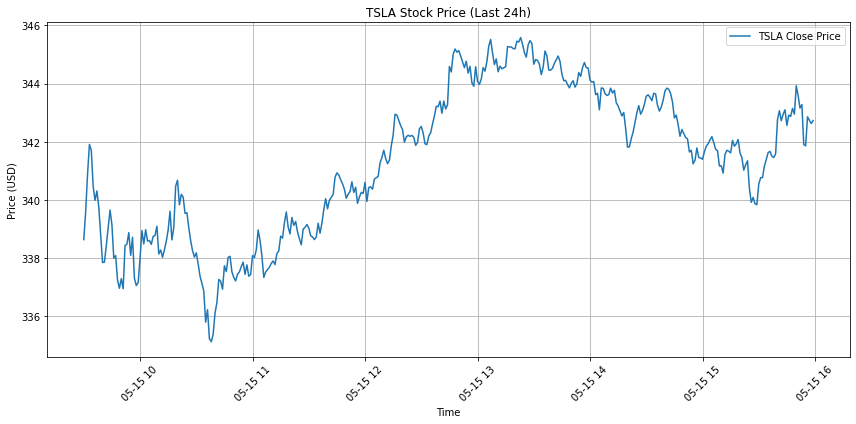

In [7]:
import matplotlib.pyplot as plt

# Load and convert timestamp
stock_df = pd.read_csv("tsla_price.csv")
stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'])

# Remove timezone 
stock_df['timestamp'] = stock_df['timestamp'].dt.tz_localize(None)

# Convert to numpy arrays
x = stock_df['timestamp'].to_numpy()
y = stock_df['close_price'].to_numpy()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, y, label="TSLA Close Price")
plt.title("TSLA Stock Price (Last 24h)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
